In [5]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, Multiply, Add, Layer, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow.keras.optimizers import Adam
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Custom Layer to subtract from 1
class SubtractFromOne(Layer):
    def call(self, inputs):
        return 1.0 - inputs

# Custom Layer to extract a specific feature (replacing Lambda layers that slice inputs)
class ExtractFeature(Layer):
    def __init__(self, index, **kwargs):
        super(ExtractFeature, self).__init__(**kwargs)
        self.index = index

    def call(self, inputs):
        return inputs[:, :, self.index]

# Custom R2 score metric
def r2_score_metric(y_true, y_pred):
    SS_res = tf.reduce_sum(tf.square(y_true - y_pred)) 
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true))) 
    return 1 - SS_res / (SS_tot + tf.keras.backend.epsilon())

def train_and_evaluate_gru_model(target_variable, flag_train=True, _epochs=100, _batch_size=10):
    mgh_data = pd.read_excel("gru-datasets.xlsx")
    features = ['timesteps', f'{target_variable} (Predicted GL)', f'{target_variable} (Predicted NN)']
    
    X = mgh_data[features]
    y = mgh_data[f'{target_variable} (Actual)']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42)
    X_train_reshaped = X_train.values.reshape((X_train.shape[0], -1, X_train.shape[1]))
    X_test_reshaped = X_test.values.reshape((X_test.shape[0], -1, X_test.shape[1]))

    if flag_train:
        time_steps = X_train_reshaped.shape[1]
        features_count = X_train_reshaped.shape[2]

        # Define the input layer with the appropriate shape
        input_layer = Input(shape=(time_steps, features_count), name='input_layer')

        # First GRU layer with 64 units and dropout
        gru_output_1 = GRU(units=64, return_sequences=True)(input_layer)
        dropout_1 = Dropout(0.2)(gru_output_1)

        # Second GRU layer with 32 units and dropout
        gru_output_2 = GRU(units=32, return_sequences=True)(dropout_1)
        dropout_2 = Dropout(0.2)(gru_output_2)

        # Third GRU layer with 16 units and dropout
        gru_output_3 = GRU(units=16, return_sequences=False)(dropout_2)
        dropout_3 = Dropout(0.2)(gru_output_3)

        # Dense layer followed by dropout
        w_physics = Dense(1, activation='sigmoid')(dropout_3)
        # w_physics_dropout = Dropout(0.2)(w_physics)

        # Custom layer to subtract from 1
        w_nn = SubtractFromOne()(w_physics)

        # Extract specific features
        q_physics_input = ExtractFeature(index=1, name='q_physics_input')(input_layer)
        q_nn_input = ExtractFeature(index=2, name='q_nn_input')(input_layer)

        # Calculate the final output
        y_hat_physics = Multiply()([q_physics_input, w_physics])
        y_hat_nn = Multiply()([q_nn_input, w_nn])
        y_hat = Add()([y_hat_physics, y_hat_nn])

        # Create the model
        model = Model(inputs=input_layer, outputs=y_hat)
        
        adam = Adam(learning_rate=0.001, use_ema=True, ema_momentum=0.9)
        
        model.compile(optimizer=adam, loss='mse', metrics=['mae', r2_score_metric])

        history = model.fit(X_train_reshaped, y_train, epochs=_epochs, batch_size=_batch_size, validation_split=0.2, verbose=1)

        # Save model architecture and weights
        model_json = model.to_json()
        with open(f"gru-dropout-models/{target_variable.replace(' ', '_')}_gru_model.json", "w") as json_file:
            json_file.write(model_json)
        model.save_weights(f"gru-dropout-models/{target_variable.replace(' ', '_')}_gru_model.weights.h5")

        # Predict the test set after training
        y_hat_test = model.predict(X_test_reshaped)

    else:
        # Load model architecture and weights
        with open(f"gru-dropout-models/{target_variable.replace(' ', '_')}_gru_model.json", "r") as json_file:
            loaded_model_json = json_file.read()
            loaded_model = tf.keras.models.model_from_json(loaded_model_json, custom_objects={'r2_score_metric': r2_score_metric, 'SubtractFromOne': SubtractFromOne, 'ExtractFeature': ExtractFeature})

        loaded_model.load_weights(f"gru-dropout-models/{target_variable.replace(' ', '_')}_gru_model.weights.h5")
        loaded_model.compile(optimizer='adam', loss='mse', metrics=['mae', r2_score_metric])

        # Predict the test set using the loaded model
        y_hat_test = loaded_model.predict(X_test_reshaped)

    # Evaluate the model
    mae = mean_absolute_error(y_test, y_hat_test)
    r2 = r2_score(y_test, y_hat_test)

    if flag_train:
        # Plot training history
        plt.figure(figsize=(6, 4))
        sns.lineplot(x=history.epoch, y=history.history['loss'], color='g', label='training')
        sns.lineplot(x=history.epoch, y=history.history['val_loss'], color='b', label='validation')
        plt.title('Model loss during training')
        plt.ylabel('loss')
        plt.xlabel('training epoch')
        plt.legend(loc='upper right')

        plt.figure(figsize=(6, 4))
        sns.lineplot(x=history.epoch, y=history.history['r2_score_metric'], color='g', label='training')
        sns.lineplot(x=history.epoch, y=history.history['val_r2_score_metric'], color='b', label='validation')
        plt.title('R2 during training')
        plt.ylabel('R2')
        plt.xlabel('epoch')
        plt.legend(loc='lower right')

    print(f"\nTarget Variable: {target_variable}")
    print(f"MAE: {mae:.2f}")
    print(f"R²: {r2:.2f}")

    # Scatter plot of actual vs. predicted values
    plt.figure(figsize=(6, 4))
    plt.scatter(y_test, y_hat_test, label='Predicted vs Actual')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Perfect Prediction')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs Predicted Values for {target_variable}\nMAE: {mae:.2f}, R²: {r2:.2f}')
    plt.legend()

    # Plot of actual vs. predicted over time
    plt.figure(figsize=(6, 4))
    plt.plot(range(len(y_test)), y_test, marker='o', linestyle='-', color='blue', label='Actual')
    plt.plot(range(len(y_hat_test)), y_hat_test, marker='x', linestyle='--', color='red', label='Predicted')
    plt.title(f'Actual vs Predicted Values for {target_variable}')
    plt.xlabel('Index')
    plt.ylabel(target_variable)
    plt.legend()
    plt.show()

Epoch 1/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 0.0939 - mae: 0.2349 - r2_score_metric: 0.5031 - val_loss: 0.0902 - val_mae: 0.2352 - val_r2_score_metric: 0.5617
Epoch 2/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1039 - mae: 0.2413 - r2_score_metric: -0.6959 - val_loss: 0.0884 - val_mae: 0.2293 - val_r2_score_metric: 0.5755
Epoch 3/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0889 - mae: 0.2181 - r2_score_metric: 0.2825 - val_loss: 0.0883 - val_mae: 0.2267 - val_r2_score_metric: 0.5812
Epoch 4/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0955 - mae: 0.2337 - r2_score_metric: 0.3127 - val_loss: 0.0892 - val_mae: 0.2253 - val_r2_score_metric: 0.5771
Epoch 5/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0913 - mae: 0.2297 - r2_score_metric: 0.4319 - val_loss: 0.0874 - val_mae: 0.2252 - val_r2_score_metric: 0.5755
Epoch 6/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0873 - mae: 0.2260 - r2_score_metric: 0.6084 - val_loss: 0.0

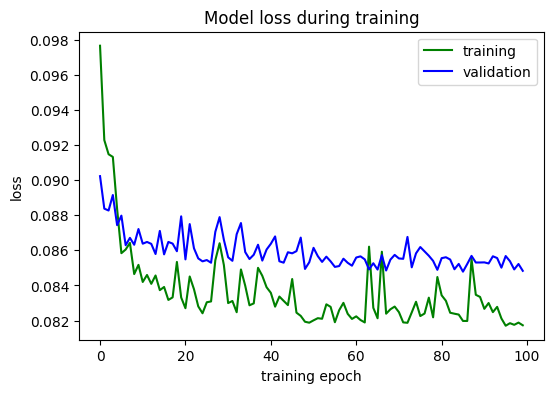

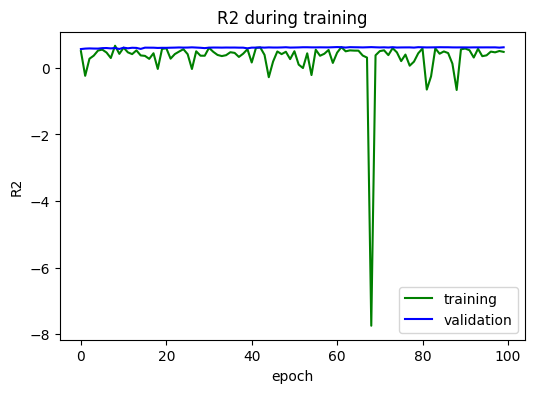

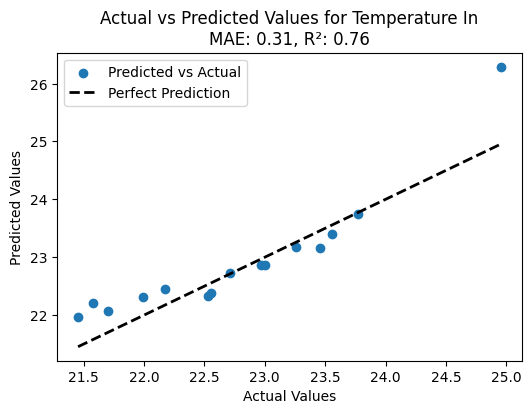

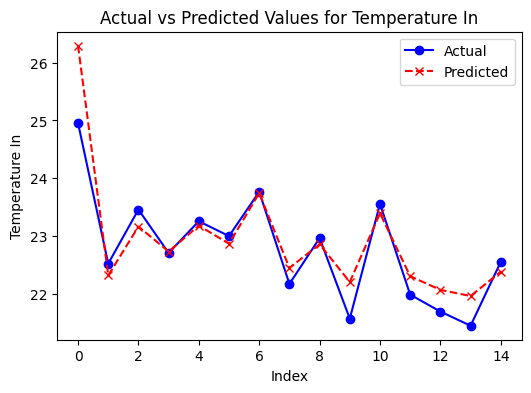

Epoch 1/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 116.7761 - mae: 8.8950 - r2_score_metric: -29.0989 - val_loss: 16.5528 - val_mae: 3.6717 - val_r2_score_metric: -2.4427
Epoch 2/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 15.7708 - mae: 3.5872 - r2_score_metric: -2.4536 - val_loss: 15.4636 - val_mae: 3.5265 - val_r2_score_metric: -2.1961
Epoch 3/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 15.1686 - mae: 3.4920 - r2_score_metric: -3.4520 - val_loss: 15.1677 - val_mae: 3.4860 - val_r2_score_metric: -2.1293
Epoch 4/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 15.2327 - mae: 3.5035 - r2_score_metric: -3.4560 - val_loss: 15.0150 - val_mae: 3.4649 - val_r2_score_metric: -2.0948
Epoch 5/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 14.6043 - mae: 3.4160 - r2_score_metric: -3.5790 - val_loss: 14.9386 - val_mae: 3.4543 - val_r2_score_metric: -2.0775
Epoch 6/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 13.5534 - mae: 3.3133 - r2_score_metric: -

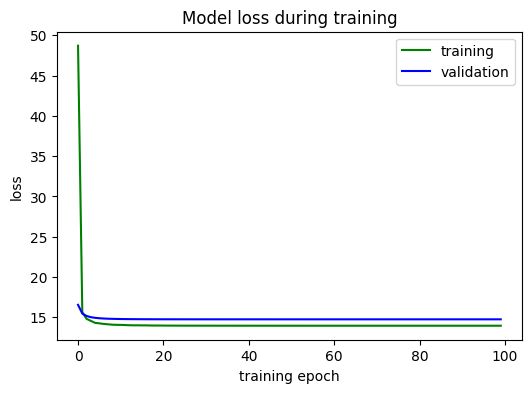

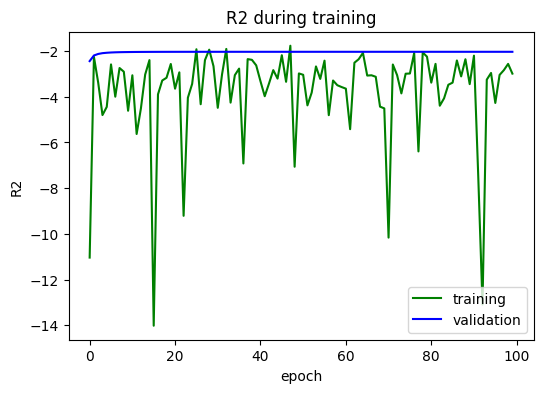

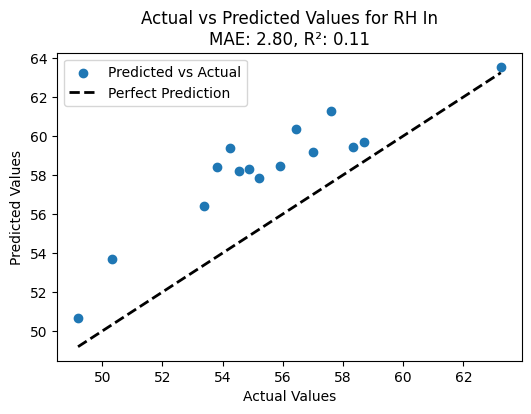

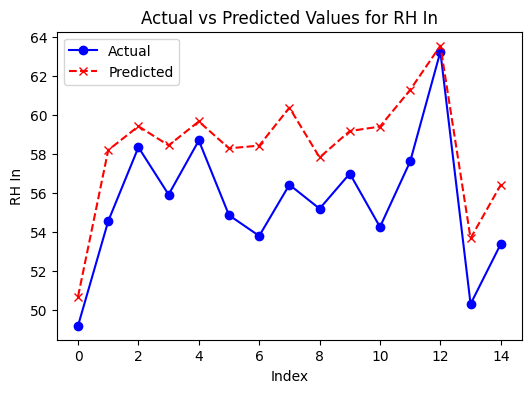

Epoch 1/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.9415 - mae: 0.7380 - r2_score_metric: -1.6867 - val_loss: 0.4003 - val_mae: 0.3733 - val_r2_score_metric: -0.2959
Epoch 2/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2630 - mae: 0.3506 - r2_score_metric: 0.6485 - val_loss: 0.3972 - val_mae: 0.3644 - val_r2_score_metric: -0.3012
Epoch 3/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2540 - mae: 0.3445 - r2_score_metric: -0.5262 - val_loss: 0.3966 - val_mae: 0.3621 - val_r2_score_metric: -0.3028
Epoch 4/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2766 - mae: 0.3489 - r2_score_metric: -0.0044 - val_loss: 0.3963 - val_mae: 0.3611 - val_r2_score_metric: -0.3038
Epoch 5/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2580 - mae: 0.3442 - r2_score_metric: 0.6860 - val_loss: 0.3961 - val_mae: 0.3604 - val_r2_score_metric: -0.3043
Epoch 6/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2613 - mae: 0.3461 - r2_score_metric: -0.2054 - val_l

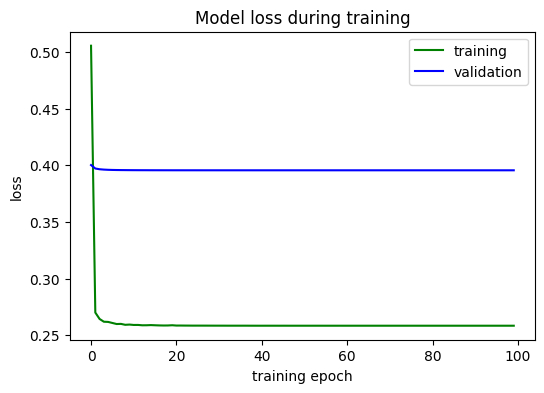

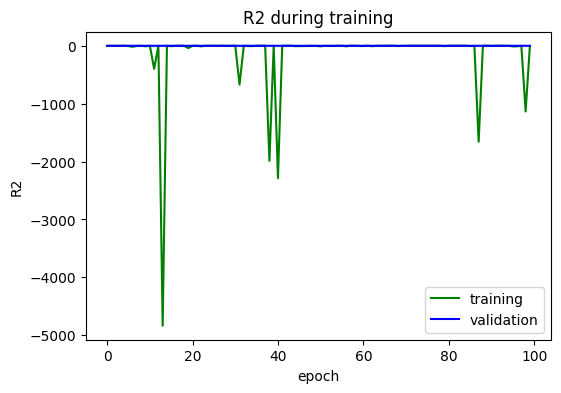

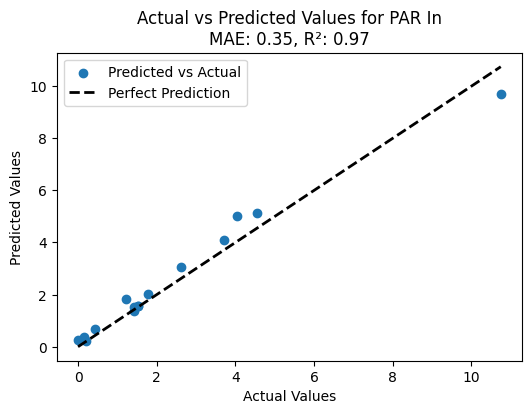

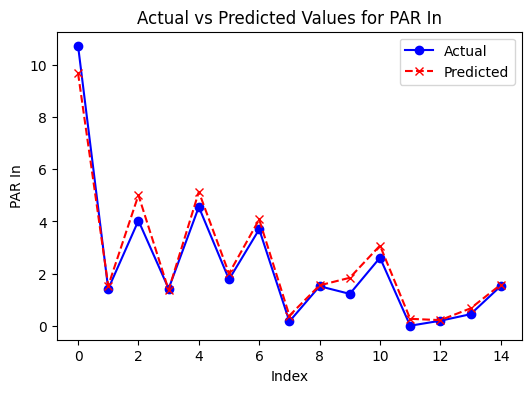

Epoch 1/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 24.9707 - mae: 3.6618 - r2_score_metric: -654792192.0000 - val_loss: 17.2508 - val_mae: 2.9165 - val_r2_score_metric: -299853024.0000
Epoch 2/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 15.0537 - mae: 2.8451 - r2_score_metric: -274429376.0000 - val_loss: 15.9717 - val_mae: 2.7452 - val_r2_score_metric: -288242976.0000
Epoch 3/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 15.6382 - mae: 2.8624 - r2_score_metric: -340577504.0000 - val_loss: 16.0135 - val_mae: 2.7553 - val_r2_score_metric: -285919360.0000
Epoch 4/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 16.2358 - mae: 2.9211 - r2_score_metric: -321777696.0000 - val_loss: 16.2225 - val_mae: 2.7715 - val_r2_score_metric: -285131360.0000
Epoch 5/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 14.9535 - mae: 2.8046 - r2_score_metric: -321993920.0000 - val_loss: 16.7771 - val_mae: 2.8631 - val_r2_score_metric: -290070752.0000
Epoch 6/100
286/286 ━━━━━

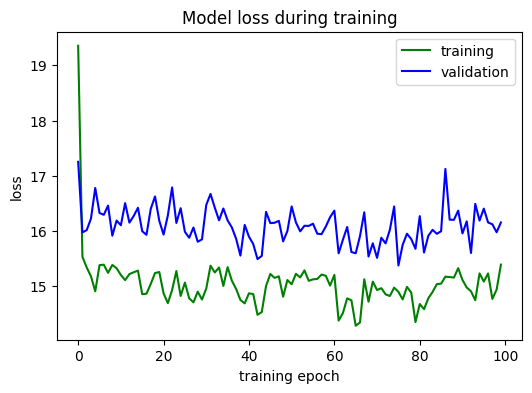

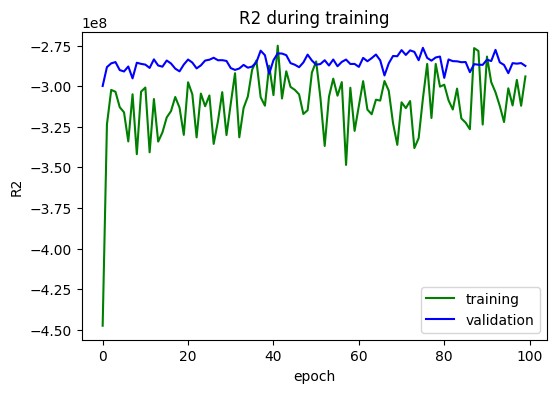

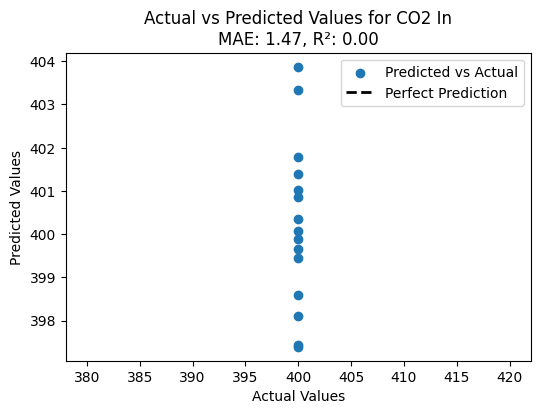

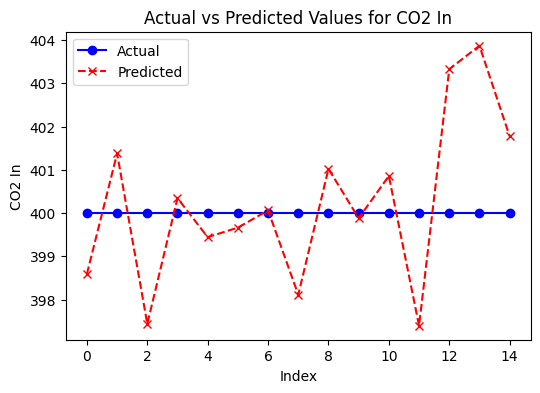

In [6]:
target_variable = ['Temperature In', 'RH In', 'PAR In', 'CO2 In']

for i in target_variable:
    train_and_evaluate_gru_model(i, flag_train=True, _epochs=100, _batch_size=4)

In [ ]:
train_and_evaluate_gru_model('Temperature In', flag_train=False)

In [ ]:
train_and_evaluate_gru_model('RH In', flag_train=False)